In [1]:
import basd
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

#### Reading NetCDF file
Reading in observational precipitation data from 1979-2014 supplied in the data directory.

In [2]:
pr_obs_hist = xr.open_dataset('../basd/data/pr_obs-hist_coarse_1979-2014.nc')
pr_sim_hist = xr.open_dataset('../basd/data/pr_sim-hist_coarse_1979-2014.nc')
pr_sim_fut = xr.open_dataset('../basd/data/pr_sim-fut_coarse_2065-2100.nc')

### Running Bias Adjustment
#### Initializing our first `Adjustment` object
Here we are providing the three required data arrays and a variable name 'pr' representing the daily mean precipitation variable. Precipitation is assumed to follow a gamma distribution, and thus requires a lower bound and lower threshold parameter. We also set trend preservation mode to be 'mixed'. Thus, we set the parameter object directly specifying:

* Lower bound = 0
* Lower threshold = 0.0000011574
* Trend preservation = mixed
* Distribution = gamma

Otherwise, we are keeping the default parameter values for the bias adjustment.

In [3]:
params = basd.Parameters(lower_bound=0, lower_threshold=0.0000011574,
                         trend_preservation='mixed', distribution='gamma')
ba = basd.Adjustment(pr_obs_hist, pr_sim_hist, pr_sim_fut, 'pr', params)

#### Running Bias Adjustment
Here we run the bias adjustment for just one grid cell. We pass in a tuple with the indexes which we wish to adjust, (0,0), which in this case correspond to the coordinates 53.5 N, 12.5 E.

In [4]:
loc = dict(lat=1, lon=1)
sim_fut_ba_loc = ba.adjust_bias_one_location(loc)

In [5]:
ba.adjust_bias(n_jobs=-1)
#ba.save_adjustment_nc('../../../Documents/pr_sim_fut_ba.nc')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    5.7s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.8s finished


<xarray.Dataset>
Dimensions:  (lat: 2, lon: 2, time: 13148)
Coordinates:
  * lat      (lat) float64 53.5 52.5
  * lon      (lon) float64 12.5 13.5
  * time     (time) datetime64[ns] 2065-01-01 2065-01-02 ... 2100-12-31
Data variables:
    pr       (lon, lat, time) float32 ...

#### Visualizing Results

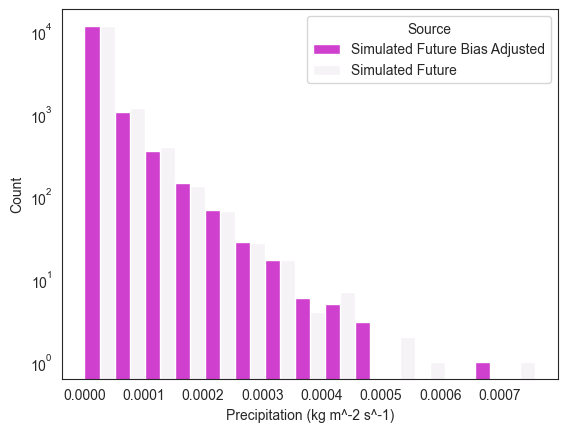

In [6]:
sim_fut_ba_loc.plot_hist(scale='log', xlab='Precipitation (kg m^-2 s^-1)')

### Daily mean near-surface air temperature
Here we are adjusting the 'tas' variable. We assume this follows the normal distribution, which is not bounded.

We also detrend this variable and use an additive trend preservation method within quantiles

Here we use month-to-month mode, and have only selected to adjust January and February.

In [7]:
tas_obs_hist = xr.open_dataset('../basd/data/tas_obs-hist_coarse_1979-2014.nc')
tas_sim_hist = xr.open_dataset('../basd/data/tas_sim-hist_coarse_1979-2014.nc')
tas_sim_fut = xr.open_dataset('../basd/data/tas_sim-fut_coarse_2065-2100.nc')
tas_params = basd.Parameters(trend_preservation='additive', distribution='normal', detrend=True, step_size=0, months=[1, 2])
tas_ba = basd.Adjustment(tas_obs_hist, tas_sim_hist, tas_sim_fut, 'tas', tas_params)
loc = dict(lat=1, lon=1)
tas_sim_fut_ba_loc = tas_ba.adjust_bias_one_location(loc)

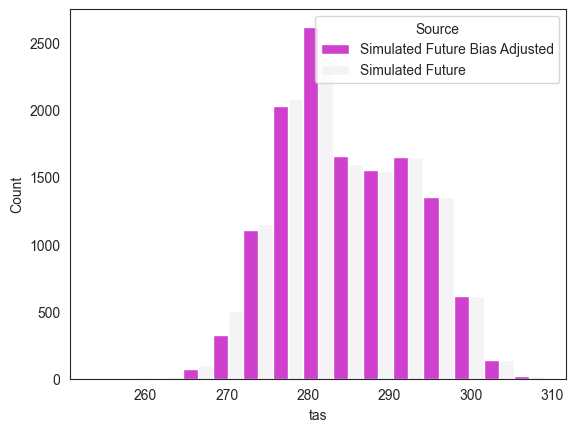

In [8]:
tas_sim_fut_ba_loc.plot_hist()